In [1]:
import pandas as pd

LOADING DATASETS

In [2]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

CHECKING FOR DATA BY DISPLAYING FEW ROWS

In [3]:
print("Customers Data")
print(customers.head())

Customers Data
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15


In [4]:
print("Products Data")
print(products.head())

Products Data
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31


In [5]:
print("Transactions Data")
print(transactions.head())

Transactions Data
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


AGGREGATING TRANSACTION DATA AT CUSTOMER LEVEL

In [6]:
transaction_features = transactions.groupby('CustomerID').agg(
    total_spent=pd.NamedAgg(column='TotalValue', aggfunc='sum'),
    avg_transaction_value=pd.NamedAgg(column='TotalValue', aggfunc='mean'),
    transaction_count=pd.NamedAgg(column='TransactionID', aggfunc='count'),
    distinct_products=pd.NamedAgg(column='ProductID', aggfunc='nunique')
).reset_index()

In [7]:
customer_data = customers.merge(transaction_features, on='CustomerID', how='left').fillna(0)
print(customer_data.head())

  CustomerID        CustomerName         Region  SignupDate  total_spent  \
0      C0001    Lawrence Carroll  South America  2022-07-10      3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13      1862.74   
2      C0003      Michael Rivera  South America  2024-03-07      2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09      5354.88   
4      C0005         Laura Weber           Asia  2022-08-15      2034.24   

   avg_transaction_value  transaction_count  distinct_products  
0                670.904                5.0                5.0  
1                465.685                4.0                4.0  
2                681.345                4.0                4.0  
3                669.360                8.0                8.0  
4                678.080                3.0                3.0  


FEATURES IDENTIFICATION

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
customer_data['RegionEncoded'] = label_encoder.fit_transform(customer_data['Region'])

In [9]:
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])
customer_data['days_since_signup'] = (pd.Timestamp.now() - customer_data['SignupDate']).dt.days

In [10]:
features = customer_data[['total_spent', 'avg_transaction_value', 'transaction_count', 
                          'distinct_products', 'RegionEncoded']]
print(features.head())

   total_spent  avg_transaction_value  transaction_count  distinct_products  \
0      3354.52                670.904                5.0                5.0   
1      1862.74                465.685                4.0                4.0   
2      2725.38                681.345                4.0                4.0   
3      5354.88                669.360                8.0                8.0   
4      2034.24                678.080                3.0                3.0   

   RegionEncoded  
0              3  
1              0  
2              3  
3              3  
4              0  


FEATURES NORMALIZATION

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)
normalized_features_df = pd.DataFrame(normalized_features, columns=features.columns)
print(normalized_features_df.head())

   total_spent  avg_transaction_value  transaction_count  distinct_products  \
0     0.314274               0.507057           0.454545                0.5   
1     0.174514               0.351956           0.363636                0.4   
2     0.255332               0.514948           0.363636                0.4   
3     0.501681               0.505890           0.727273                0.8   
4     0.190581               0.512480           0.272727                0.3   

   RegionEncoded  
0            1.0  
1            0.0  
2            1.0  
3            1.0  
4            0.0  


CUSTOMER SEGMENTATION USING HIERARCHICAL CLUSTERING ALGORITHM

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

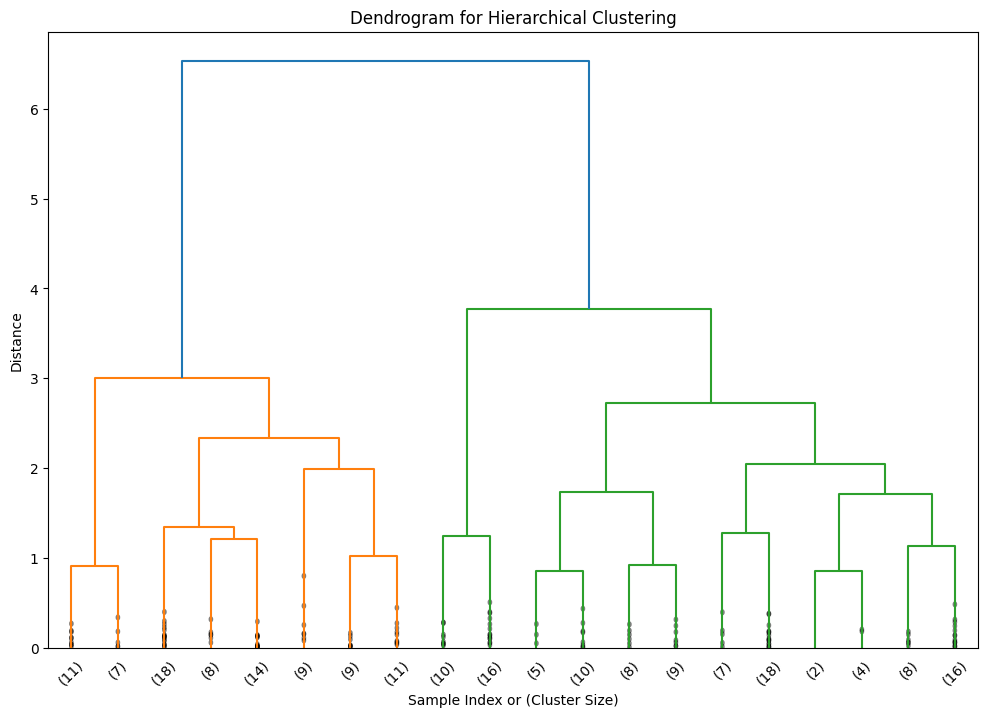

In [13]:
linkage_matrix = linkage(normalized_features_df, method='ward')
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, truncate_mode='lastp', p=20, leaf_rotation=45., leaf_font_size=10., show_contracted=True)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.show()

FIT AGGLOMERATIVE CLUSTERING

In [24]:
from sklearn.cluster import AgglomerativeClustering
num_clusters = 10  # Adjust this based on dendrogram visualization

# Apply Agglomerative Clustering
agg_cluster = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage='ward')
customer_data['Cluster'] = agg_cluster.fit_predict(normalized_features_df)
print(customer_data[['CustomerID', 'Cluster']].head())

  CustomerID  Cluster
0      C0001        0
1      C0002        2
2      C0003        3
3      C0004        0
4      C0005        2


MODEL EVALUATION USING DB INDEX (Davies-Bouldin Index), Silhouette Score, 

In [25]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(normalized_features_df, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index:.4f}")

Davies-Bouldin Index: 0.9997


In [16]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(normalized_features, customer_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.3125


CLUSTER VISUALIZATION

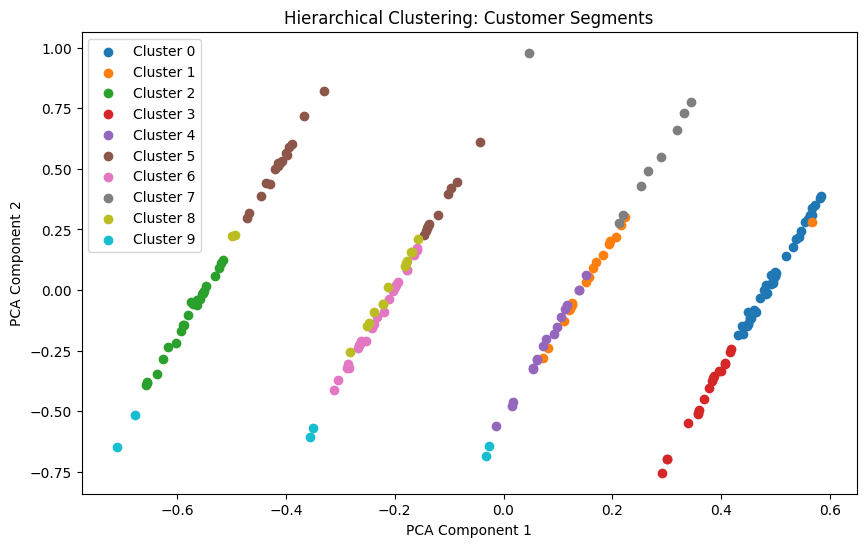

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(normalized_features_df)
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_points = pca_features[customer_data['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    
plt.title('Hierarchical Clustering: Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

CUSTOMER SEGMENTATION USING KMEANS CLUSTERING ALGORITHM

In [18]:
from sklearn.cluster import KMeans
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_data['Cluster_KMEANS'] = kmeans.fit_predict(normalized_features)
print(customer_data[['CustomerID', 'Cluster_KMEANS']].head())

  CustomerID  Cluster_KMEANS
0      C0001               1
1      C0002               2
2      C0003               1
3      C0004               9
4      C0005               2


MODEL EVALUATION USING DB INDEX (Davies-Bouldin Index), Silhouette Score,

In [19]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(normalized_features, customer_data['Cluster_KMEANS'])
print(f"Davies-Bouldin Index: {db_index:.4f}")
inertia = kmeans.inertia_
print(f"Inertia: {inertia:.4f}")

Davies-Bouldin Index: 1.0459
Inertia: 12.3782


In [20]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(normalized_features, customer_data['Cluster_KMEANS'])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Silhouette Score: 0.2874


CLUSTER VISUALIZATION

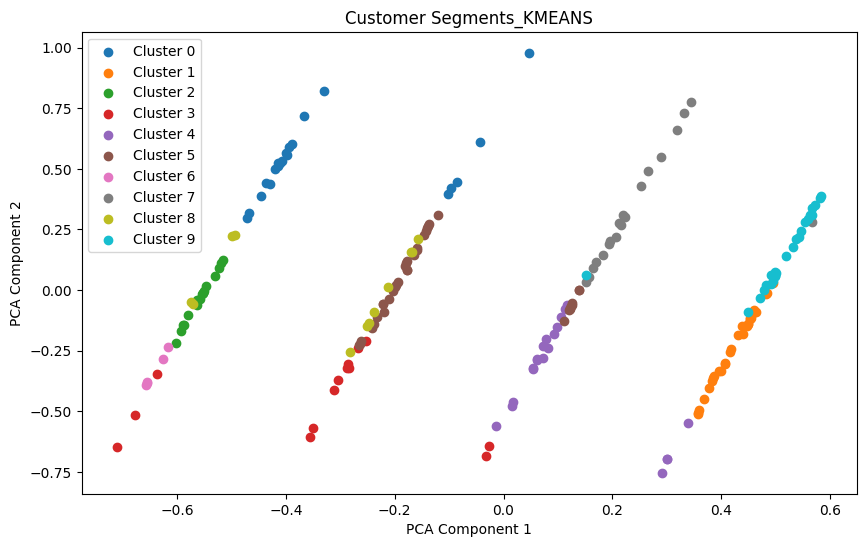

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(normalized_features)
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_points = pca_features[customer_data['Cluster_KMEANS'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    
plt.title('Customer Segments_KMEANS')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()